# Testing a simple case with 6 nodes and 1 long range edge

This notebook is set up to test a very simple use case of `feems` with the hope that this will reveal some of the underlying mechanisms of the likelihood function (i.e., complex model so adding an edge may not increase log-likelihood), estimation of residuals, etc. 

In [35]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv
from feems.helper_funcs import plot_default_vs_long_range, comp_genetic_vs_fitted_distance, plot_estimated_vs_simulated_edges

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulating use case



In [74]:
n_rows, n_columns = 2, 3
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=2.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(0,5)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.5])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 200
Simulating ~SNP 750
Simulating ~SNP 950


In [75]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

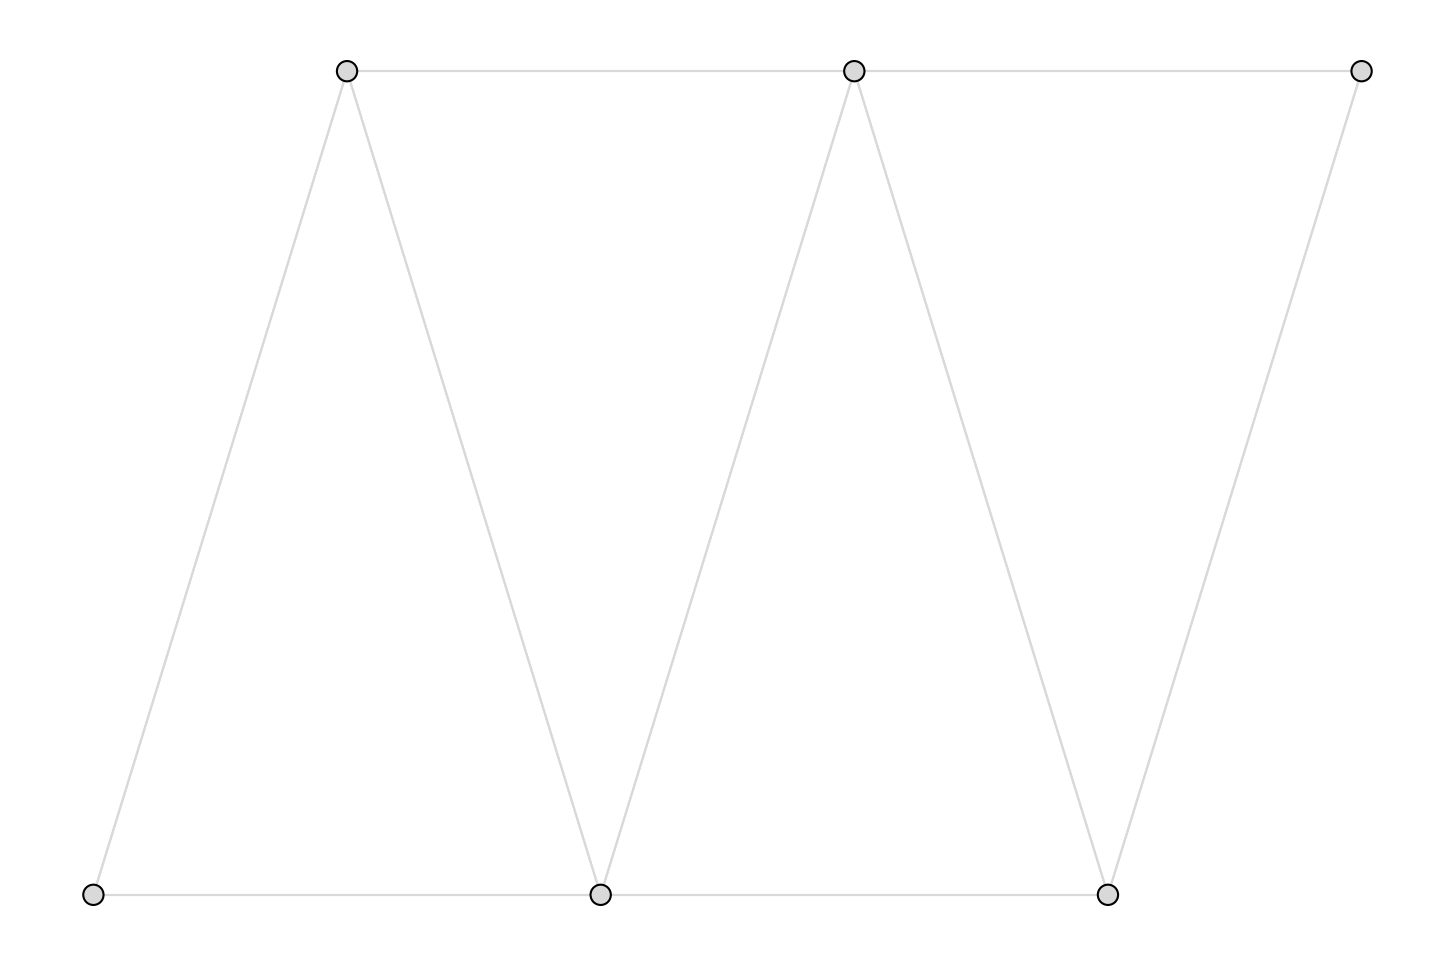

In [53]:
proj_test = ccrs.EquidistantConic(central_longitude=0.5, central_latitude=1.5)
# drawing the simulated graph 
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph_def, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [96]:
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
cv_err = run_cv(sp_Graph_def, lamb_grid, n_folds=None, factr=1e10)
lamb_cv = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1

In [97]:
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=6, lamb=lamb_cv, plotFig=False)

constant-w/variance fit, converged in 161 iterations, train_loss=-43.5204901
lambda=0.0428133, alpha=0.0817523, converged in 11 iterations, train_loss=-46.9555632


In [99]:
edges_lr = deepcopy(edge_def)
edges_lr = edges_lr.tolist()
edges_lr.append(list(x+1 for x in (0,5)))
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))

In [90]:
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
cv_err = run_cv(sp_Graph, lamb_grid, n_folds=None, factr=1e10)
lamb_cv_lr = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1

In [94]:
sp_Graph.fit(lamb=lamb_cv_lr)

constant-w/variance fit, converged in 166 iterations, train_loss=-42.5976574
lambda=0.0428133, alpha=0.0260797, converged in 16 iterations, train_loss=-45.0424709


In [95]:
obj = Objective(sp_Graph_def)
obj._solve_lap_sys()
obj._comp_mat_block_inv()
obj._comp_inv_cov()
obj_lr = Objective(sp_Graph)
obj_lr._solve_lap_sys()
obj_lr._comp_mat_block_inv()
obj_lr._comp_inv_cov()
if obj_lr.neg_log_lik() < obj.neg_log_lik():
    print("Model with long-range edges fits better by %.2f units"%(-2*(obj_lr.neg_log_lik() - obj.neg_log_lik())))

In [88]:
chi2.sf(18.90,1)

1.377526685813072e-05

### Initial takeaways:  
1. With simple graph, the `max_res_nodes` detects the correct long range edge in the top 3 everytime (it includes already connected pairs of nodes, as well -- super, super unlikely in empirical data)   
2. When adding the correct edge, there is a significant increase in the log-likelihood of the data (no other edge gives such a significant increase - nearby edge gives $p<0.05$, but not $p<1e-6$)    

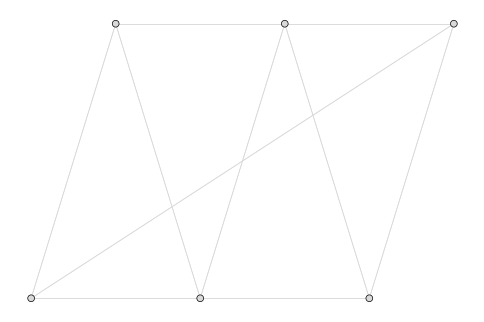

In [101]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)